# Setup notebook

In [398]:
import sys
from collections import namedtuple

import numpy as np
import pandas as pd
import seaborn as sns
sns.set()
import statsmodels.api as sm
import utide
from joblib import Parallel, delayed
from matplotlib import dates as mdates
from matplotlib import pyplot as plt
from scipy.signal import find_peaks
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.seasonal import STL, seasonal_decompose

sys.path.append("..")
from src import definitions as defs
from src import features, models

%load_ext autoreload
%autoreload 2
%matplotlib widget
%config Completer.use_jedi = False

plt.rcParams['figure.constrained_layout.use'] = True

# plt.close("all")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [460]:
wdir = defs.ROOT / "data"

In [474]:
(data.loc[data.high == True].index[1:] - data.loc[data.high == True].index[:-1]).median()

Timedelta('0 days 12:20:00')

In [400]:
correction = 0.34 - 12.1
data = pd.read_csv(wdir / "raw" / "sutarkhali_raw.csv", index_col="datetime", parse_dates=True, infer_datetime_format=True, squeeze=True)
data = data + correction

In [401]:
data = data.loc[~data.index.duplicated(keep="last")]
data = data.reindex(index=pd.date_range(start=data.index[0], end=data.index[-1], freq="10T"))

In [402]:
def find_gaps(data):
    nulls = data.loc[data.isnull()]
    starts = nulls.loc[nulls.index - nulls.index.to_series().shift(1) != pd.Timedelta("10T")]
    ends = nulls.loc[nulls.index.to_series().shift(-1) - nulls.index != pd.Timedelta("10T")]
    gaps = starts.index.to_frame(name="start").reset_index(drop=True)
    gaps["end"] = ends.index
    gaps["length"] = gaps.end - gaps.start
    return(gaps)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
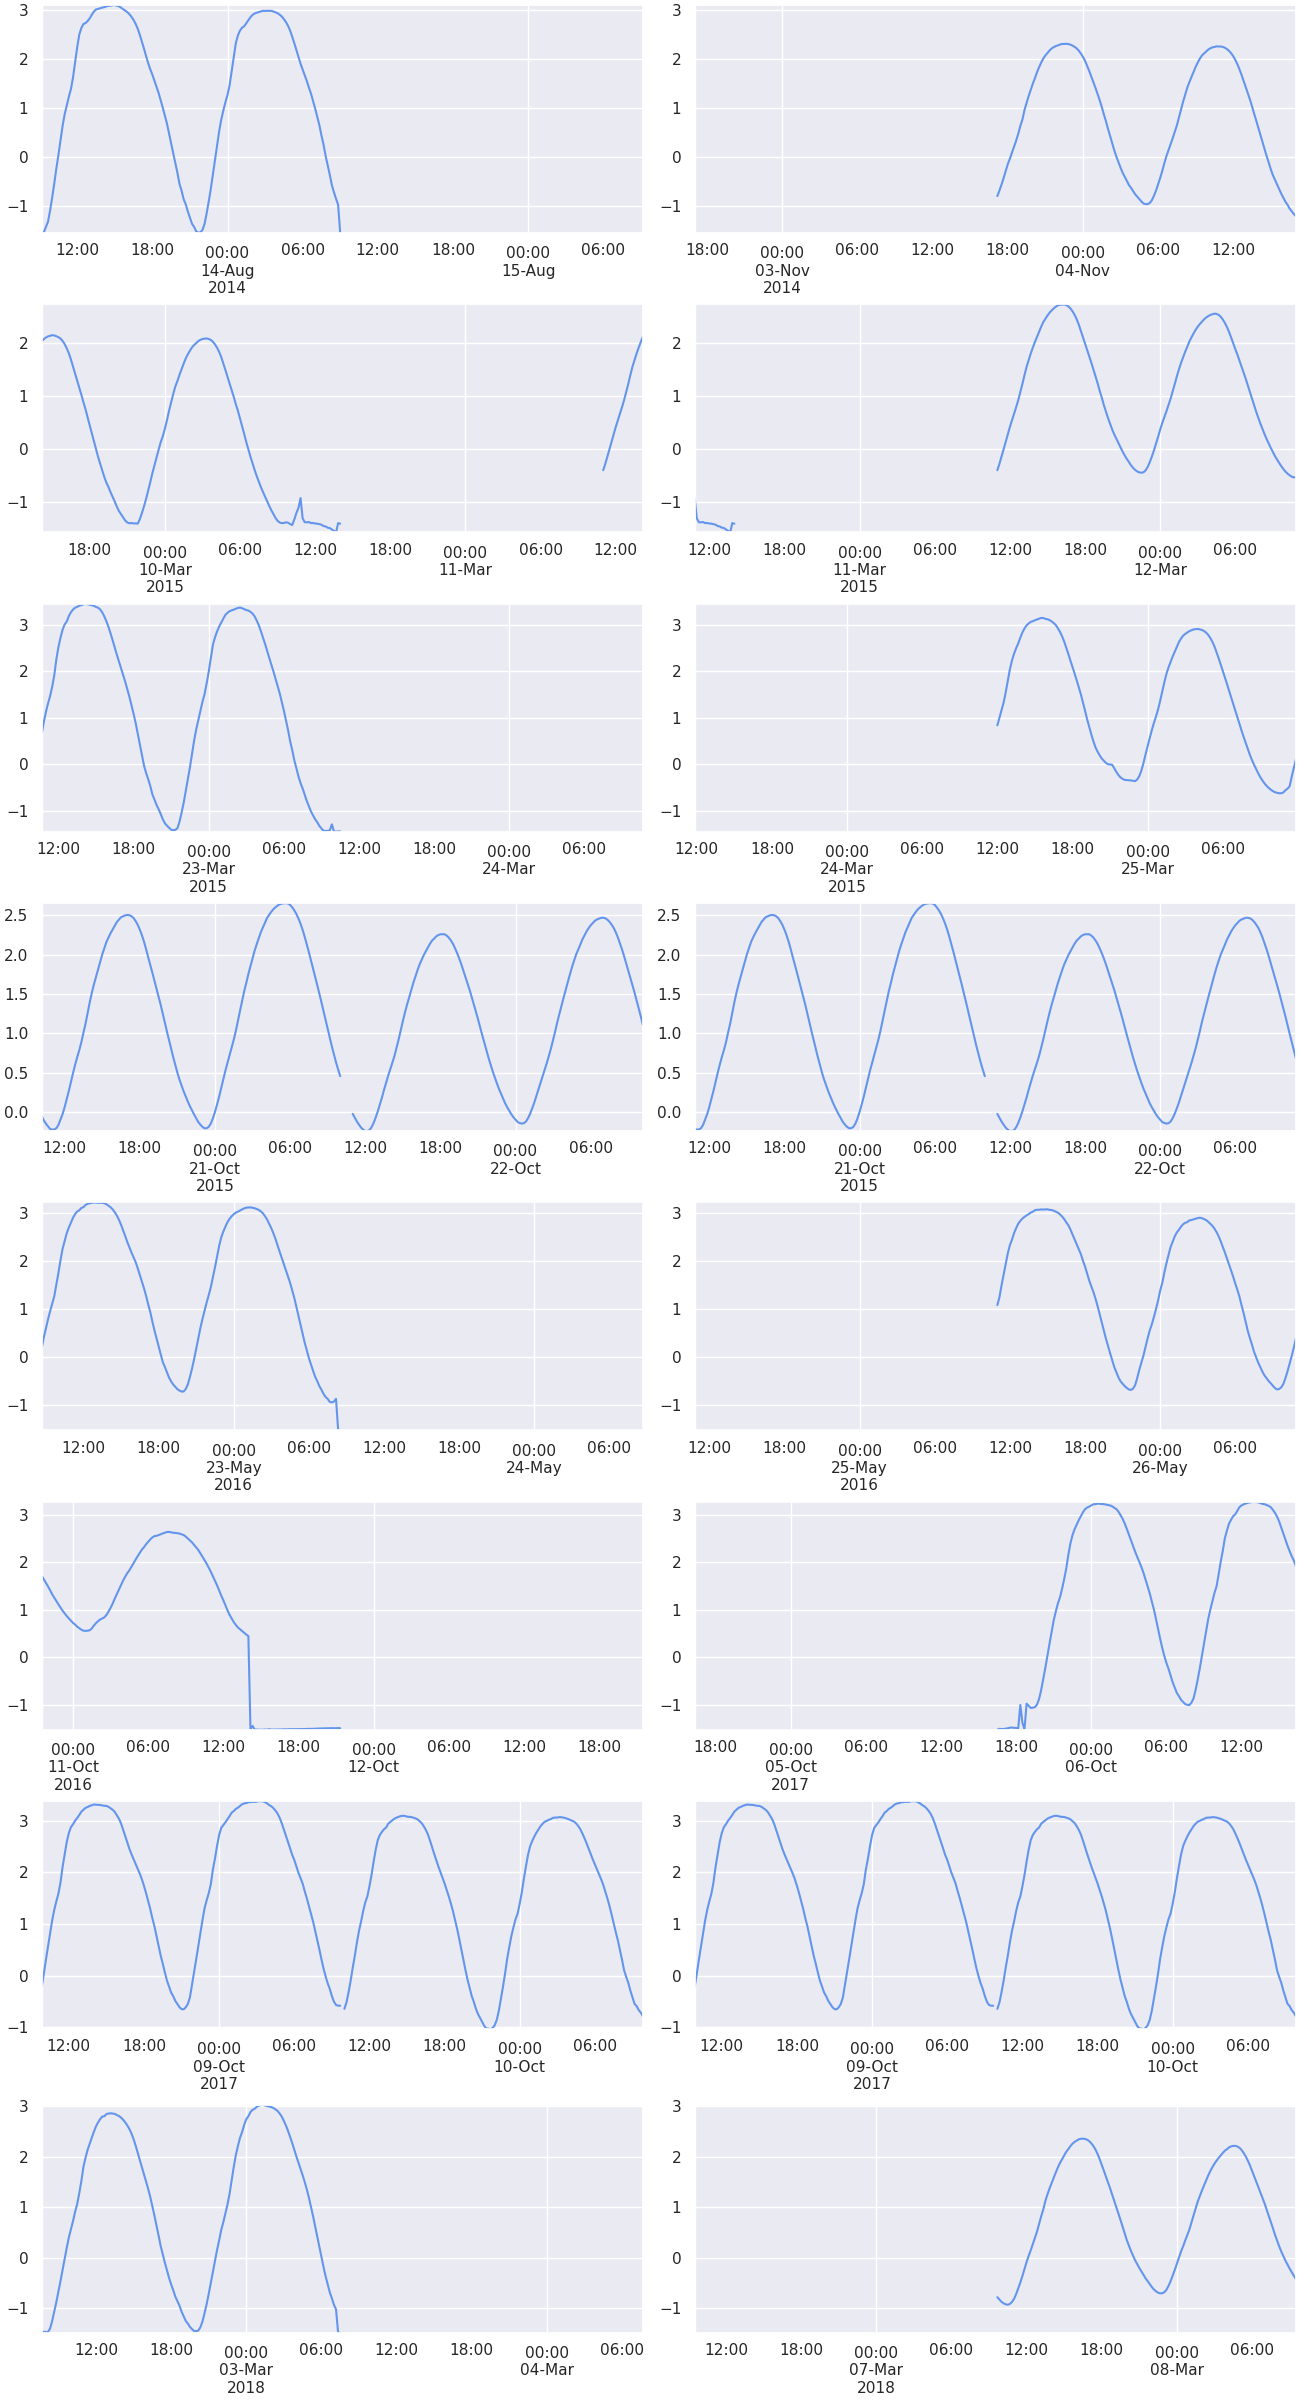

In [403]:
gaps = find_gaps(data)

fig, ax = plt.subplots(figsize=(13, 3*len(gaps)), nrows=len(gaps), ncols=2, constrained_layout=True)

window = pd.Timedelta("14D")
pwindow = pd.Timedelta("1D")

for gap in gaps.itertuples():

    data.loc[gap.start-pwindow:gap.start+pwindow].plot(color="cornflowerblue", ax=ax[gap.Index, 0], label="Obs")
    data.loc[gap.end-pwindow:gap.end+pwindow].plot(color="cornflowerblue", ax=ax[gap.Index, 1], label="Obs")

    ax[gap.Index, 0].set_ylim(data.loc[gap.start-pwindow:gap.end+pwindow].min(), data.loc[gap.start-pwindow:gap.end+pwindow].max())
    ax[gap.Index, 1].set_ylim(data.loc[gap.start-pwindow:gap.end+pwindow].min(), data.loc[gap.start-pwindow:gap.end+pwindow].max())

In [404]:
bad1 = data.loc["2015-03-10 11:00:00":"2015-03-10 14:00:00"].index
bad2 = data.loc["2015-03-23 10:00:00":"2015-03-23 10:30:00"].index
bad3 = data.loc["2015-09-09 16:30:00":"2015-09-09 18:00:00"].index
bad4 = data.loc["2016-05-23 08:20:00":"2016-05-23 08:30:00"].index
bad5 = data.loc["2016-10-11 14:10:00":"2016-10-11 21:20:00"].index
bad6 = data.loc["2017-10-05 16:30:00":"2017-10-05 18:40:00"].index

bad = bad1.append([bad2, bad3, bad4, bad5, bad6])

data.loc[bad] = np.nan

# data = data.rolling(window=pd.Timedelta("1H"), center=True).median()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
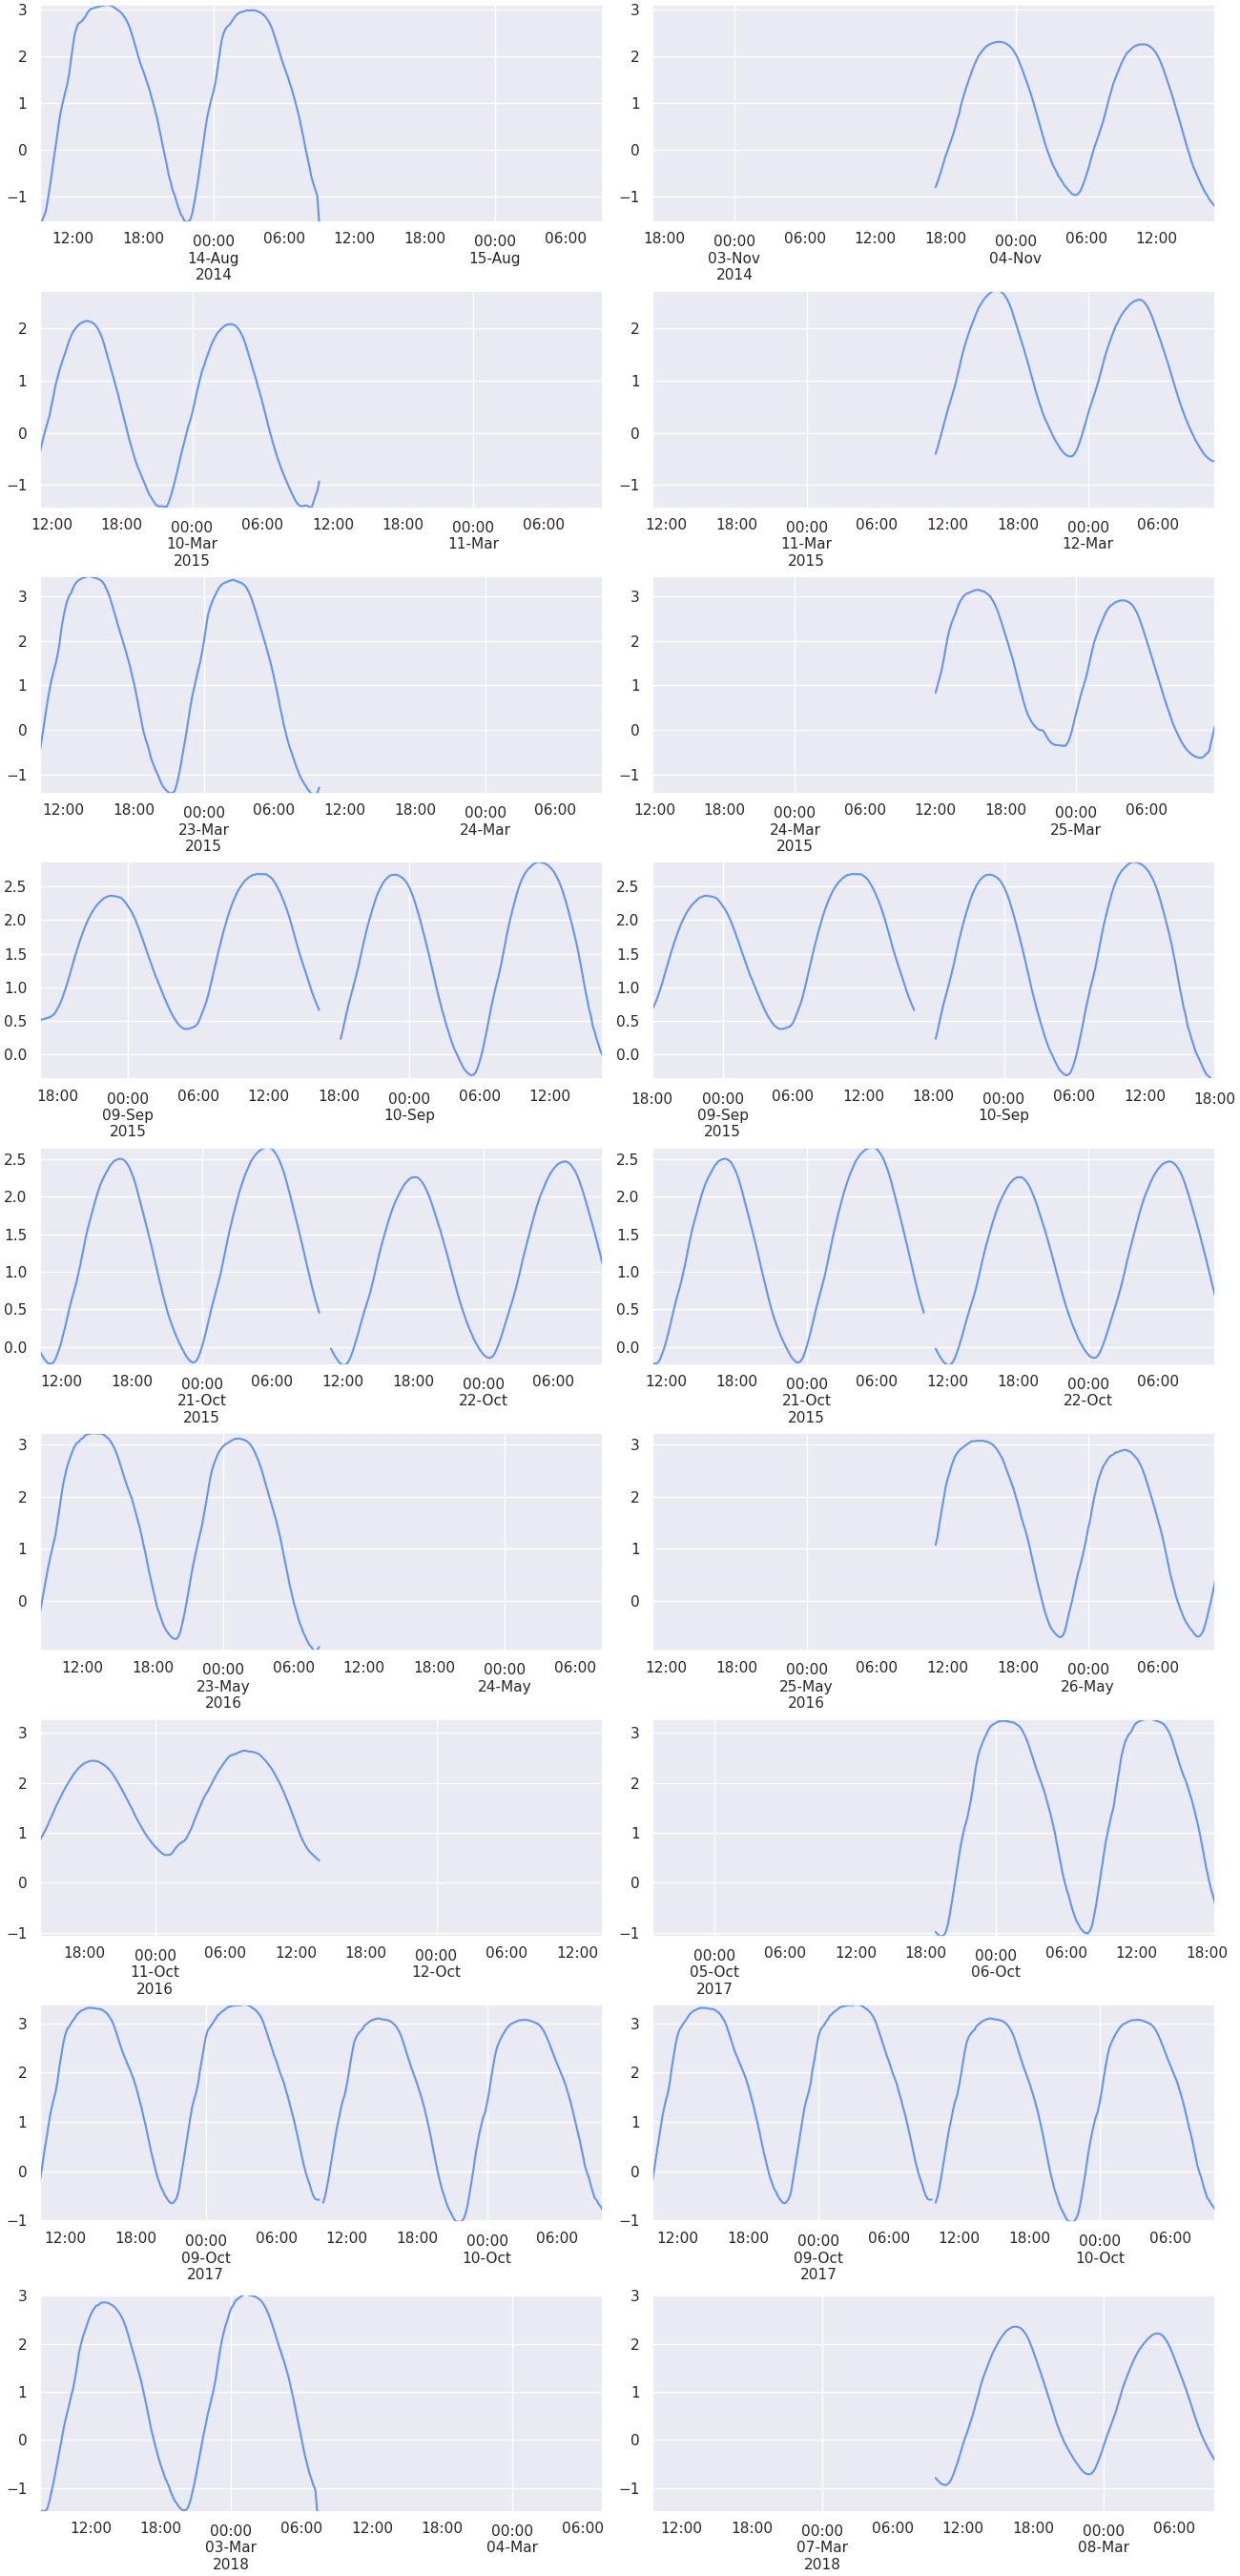

In [405]:
gaps = find_gaps(data)

fig, ax = plt.subplots(figsize=(13, 3*len(gaps)), nrows=len(gaps), ncols=2, constrained_layout=True)

window = pd.Timedelta("14D")
pwindow = pd.Timedelta("1D")

for gap in gaps.itertuples():

    data.loc[gap.start-pwindow:gap.start+pwindow].plot(color="cornflowerblue", ax=ax[gap.Index, 0], label="Obs")
    data.loc[gap.end-pwindow:gap.end+pwindow].plot(color="cornflowerblue", ax=ax[gap.Index, 1], label="Obs")

    ax[gap.Index, 0].set_ylim(data.loc[gap.start-pwindow:gap.end+pwindow].min(), data.loc[gap.start-pwindow:gap.end+pwindow].max())
    ax[gap.Index, 1].set_ylim(data.loc[gap.start-pwindow:gap.end+pwindow].min(), data.loc[gap.start-pwindow:gap.end+pwindow].max())

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
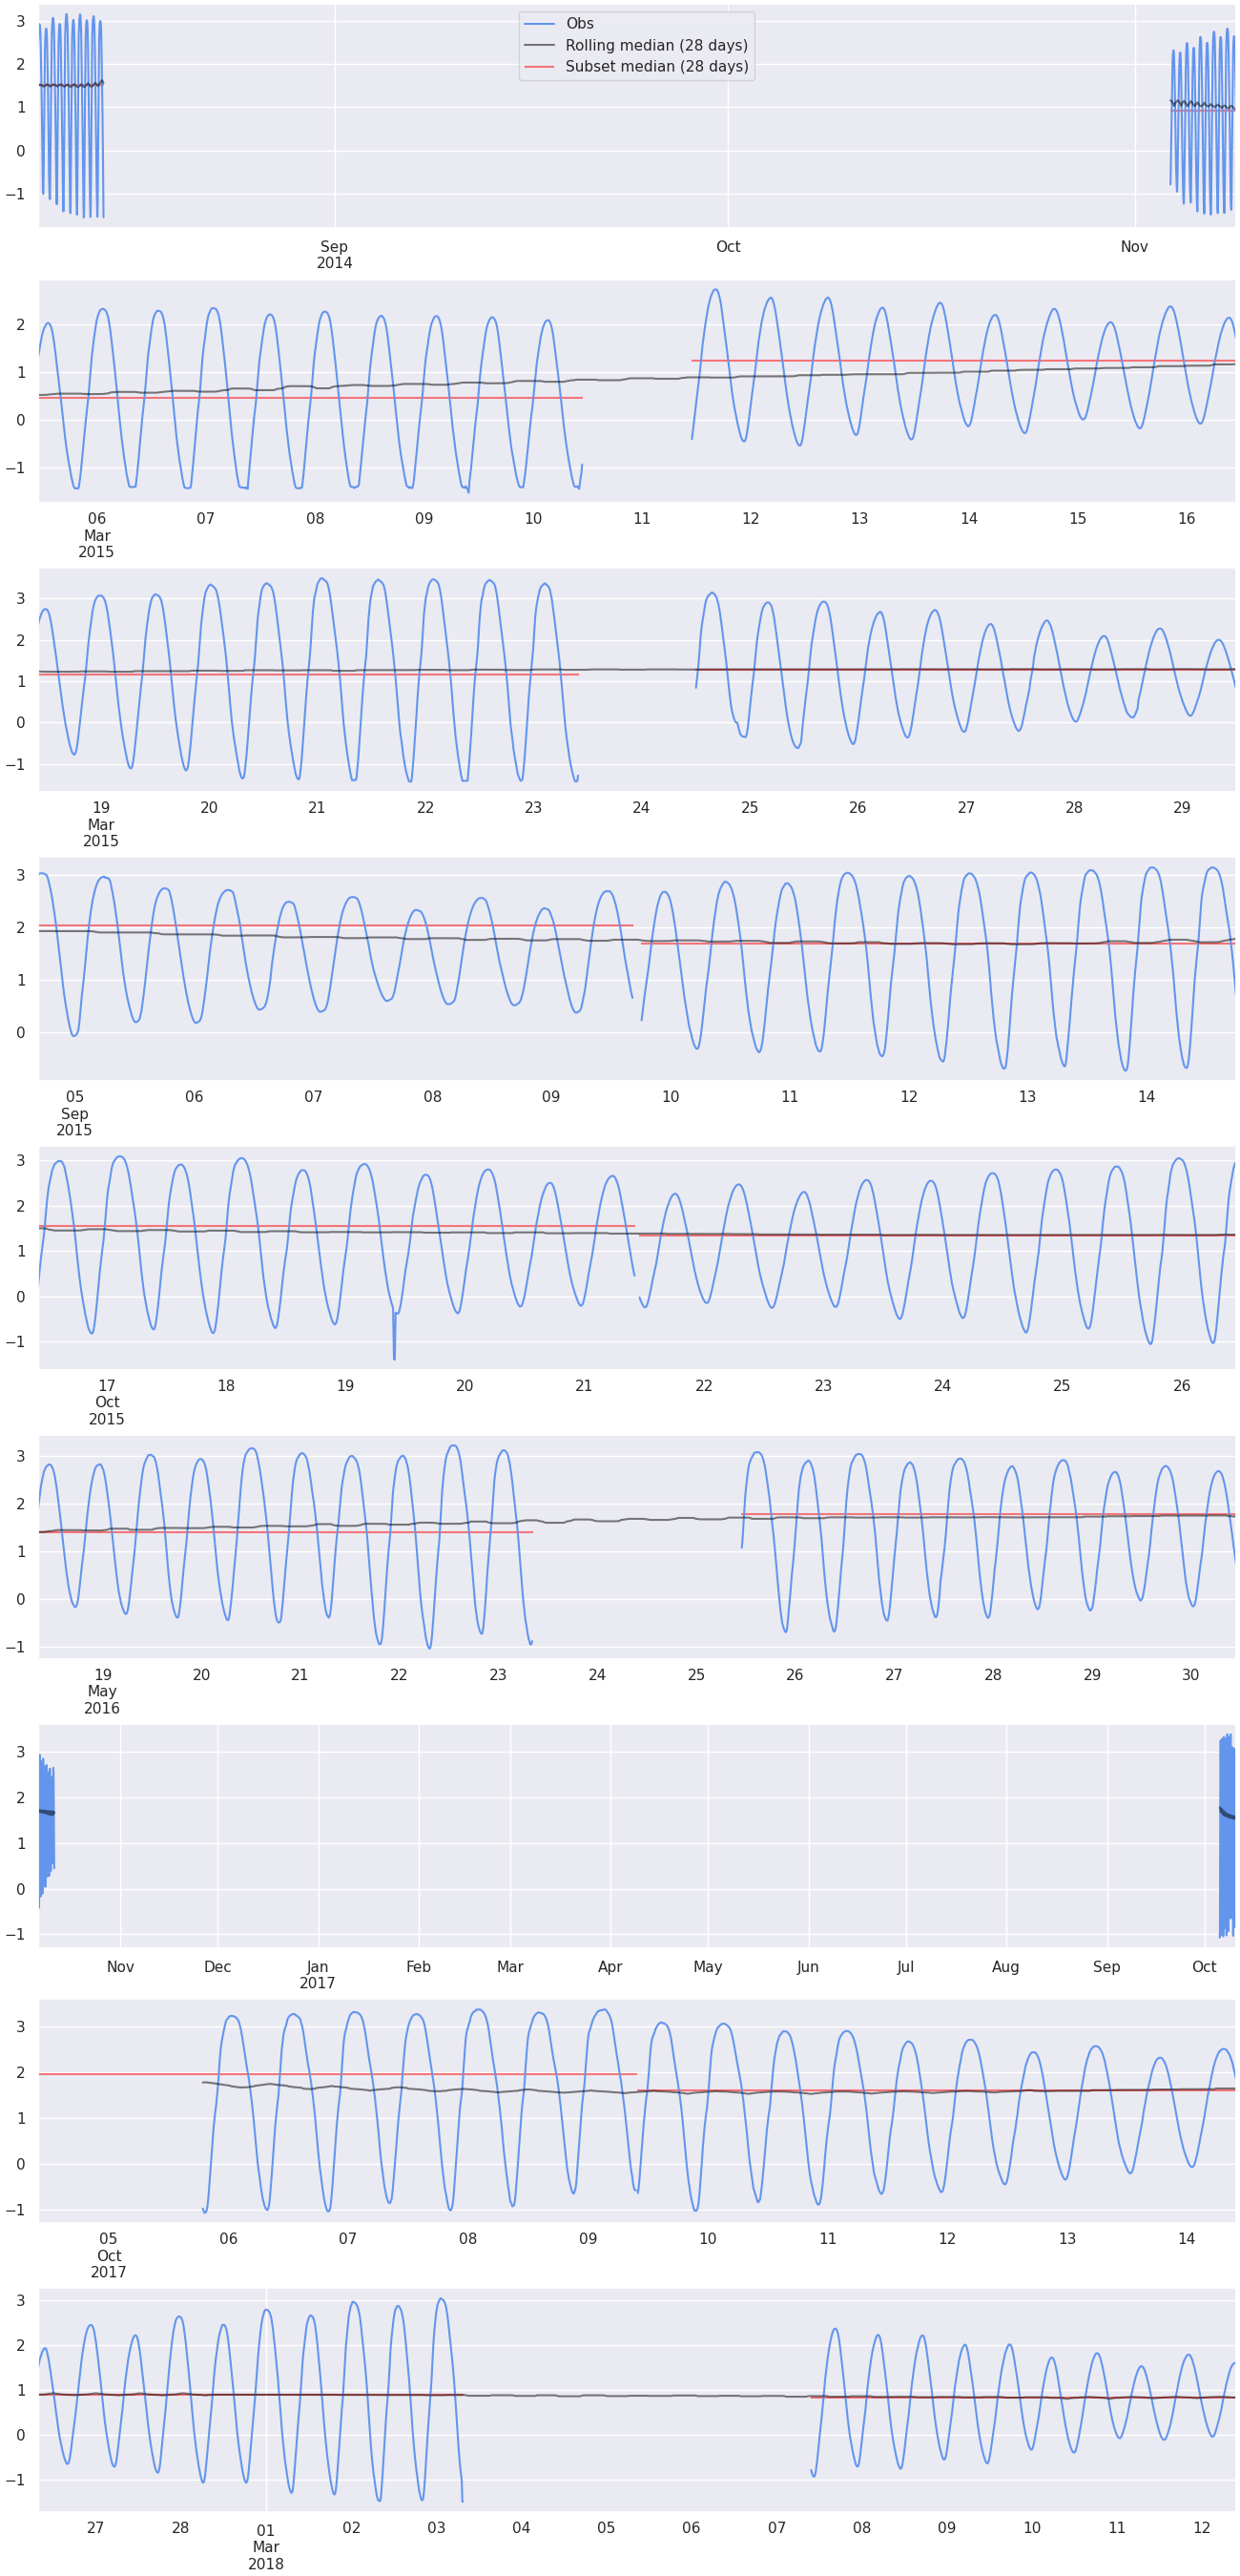

In [406]:
fig, ax = plt.subplots(figsize=(13, 3*len(gaps)), nrows=len(gaps), constrained_layout=True)

window = pd.Timedelta("14D")
pwindow = pd.Timedelta("5D")

for gap in gaps.itertuples():

    start = gap.start - pwindow
    end = gap.end + pwindow

    data.loc[start:end].plot(color="cornflowerblue", ax=ax[gap.Index], label="Obs")
    data.rolling(window=window, center=True, min_periods=pd.Timedelta("7D")//data.index.freq).median().loc[start:end].plot(color="black", alpha=0.5, ax=ax[gap.Index], label="Rolling median (28 days)")

    left_median = data.loc[gap.start-window:gap.start].median()
    right_median = data.loc[gap.end:gap.end+window].median()

    ax[gap.Index].hlines(y=left_median, xmin=start, xmax=gap.start, color="red", alpha=0.5, label="Subset median (28 days)")
    ax[gap.Index].hlines(y=right_median, xmin=gap.end, xmax=end, color="red", alpha=0.5)

    ax[gap.Index].set_xlabel("")

ax[0].legend()

In [407]:
to_adjust = gaps.loc[[1, 2, 3, 4, 5]].reset_index(drop=True)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
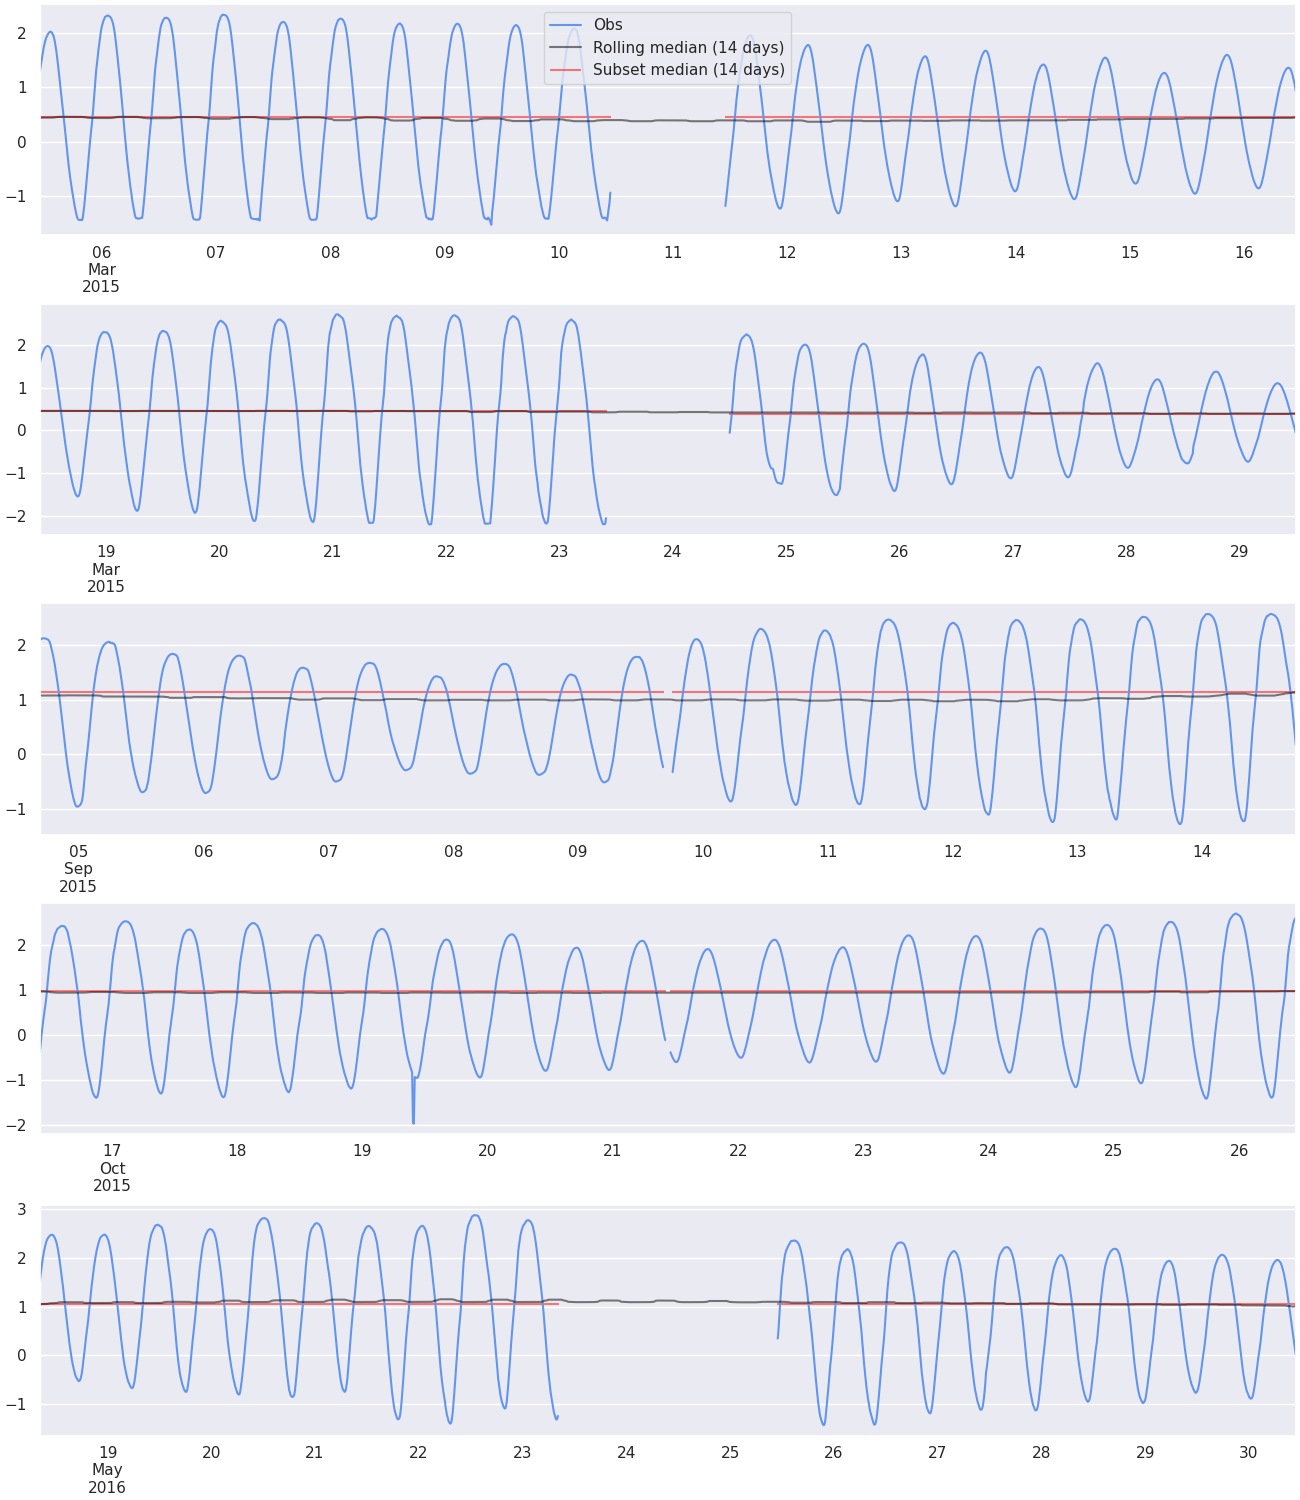

In [408]:
fig, ax = plt.subplots(figsize=(13, 3*len(to_adjust)), nrows=len(to_adjust), constrained_layout=True)

window = pd.Timedelta("14D")
pwindow = pd.Timedelta("5D")

new = data.copy()

for gap in to_adjust.itertuples():

    gap_diff = data.loc[gap.start-window:gap.start].median() - data.loc[gap.end:gap.end+window].median()

    new.loc[gap.end:] = new.loc[gap.end:] + gap_diff

    start = gap.start - pwindow
    end = gap.end + pwindow

    new.loc[start:end].plot(color="cornflowerblue", ax=ax[gap.Index], label="Obs")
    new.rolling(window=window, center=True).median().loc[start:end].plot(color="black", alpha=0.5, ax=ax[gap.Index], label="Rolling median (14 days)")

    left_median = new.loc[gap.start-window:gap.start].median()
    right_median = new.loc[gap.end:gap.end+window].median()

    ax[gap.Index].hlines(y=left_median, xmin=start, xmax=gap.start, color="red", alpha=0.5, label="Subset median (14 days)")
    ax[gap.Index].hlines(y=right_median, xmin=gap.end, xmax=end, color="red", alpha=0.5)

    ax[gap.Index].set_xlabel("")

ax[0].legend()

In [409]:
data = new

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
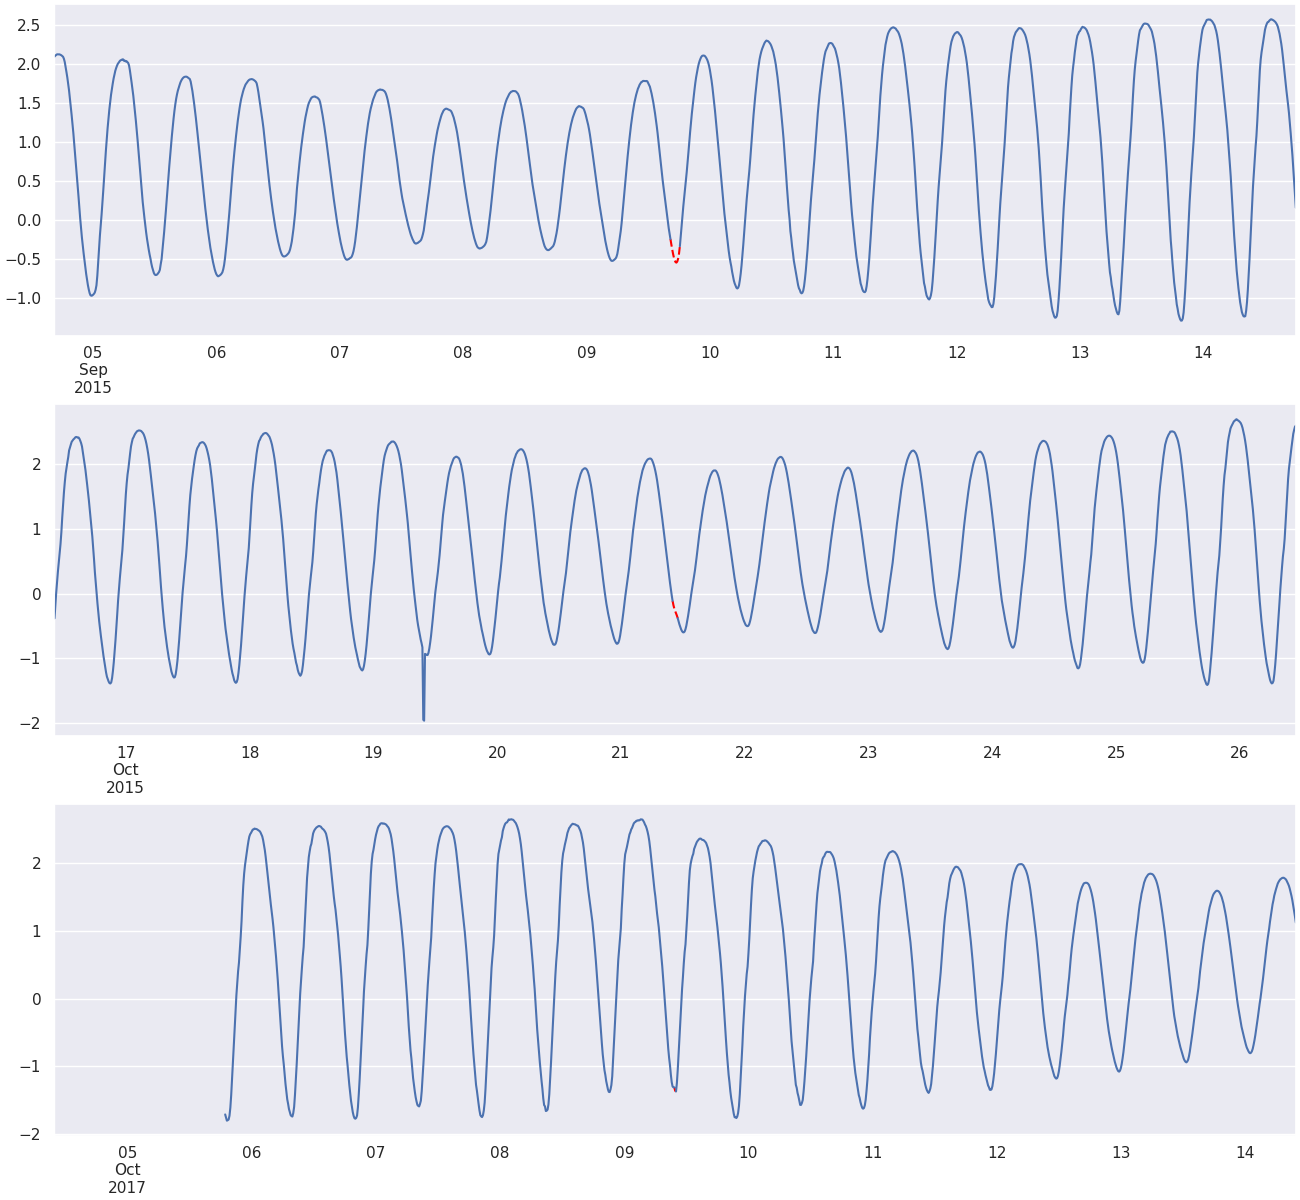

In [410]:
small_gaps = gaps.loc[gaps.length<pd.Timedelta("2H")].reset_index(drop=True)

interp = data.interpolate(method="cubicspline", limit_direction="both")

fig, ax = plt.subplots(figsize=(13, 4*len(small_gaps)), nrows=len(small_gaps), constrained_layout=True)

for gap in small_gaps.itertuples():
    interp.loc[gap.start-pd.Timedelta("10T"):gap.end+pd.Timedelta("10T")].plot(ax=ax[gap.Index], color="red", ls="--")
    data.loc[gap.start-pd.Timedelta("5D"):gap.end+pd.Timedelta("5D")].plot(ax=ax[gap.Index], alpha=1)

In [411]:
for gap in small_gaps.itertuples():
    data.loc[gap.start:gap.end] = interp.loc[gap.start:gap.end]

In [412]:
data = data.rolling(window=pd.Timedelta("1H"), center=True).median()

In [413]:
gaps = find_gaps(data)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
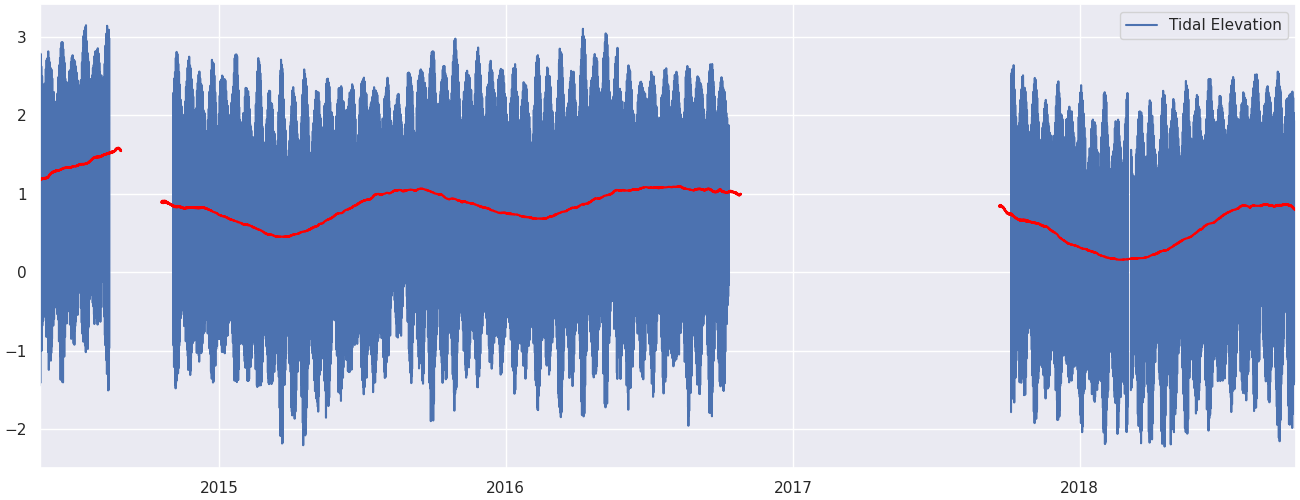

In [414]:
fig, ax = plt.subplots(figsize=(13, 5), constrained_layout=True)

window = pd.Timedelta("90D")
min_periods = pd.Timedelta("30D") // data.index.freq
n = 12

data.iloc[::n].plot(kind="line", ax=ax, label="Tidal Elevation", legend=True)
data.rolling(window=window, center=True, min_periods=min_periods).median().iloc[::n].plot(kind="line", ax=ax, color="red")

ax.set_xlim(data.index[0], data.index[-1])
ax.set_xlabel("");

(0.0, 11706.0)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
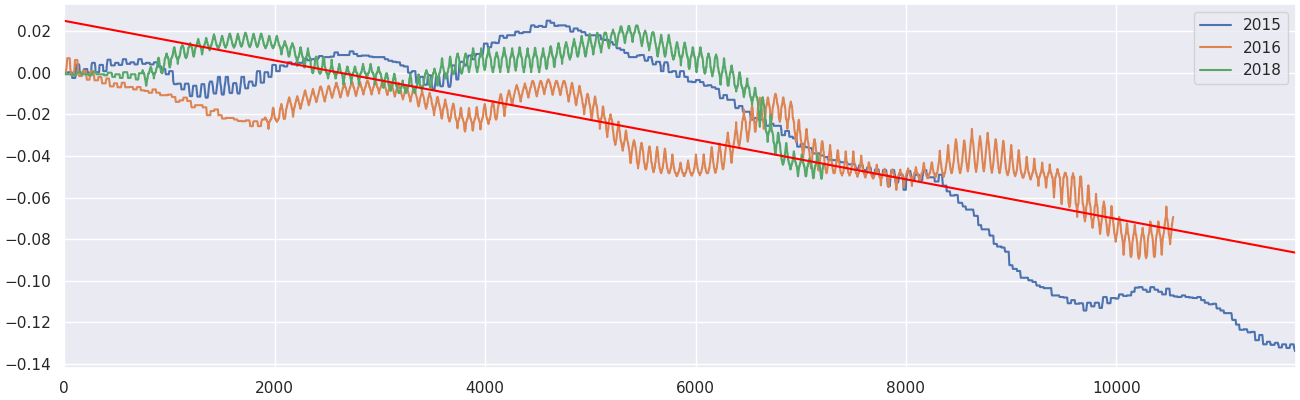

In [415]:
gap = gaps.loc[0]

window = pd.Timedelta("90D")
min_periods = window / 3 // data.index.freq

roll = data.rolling(window=window, center=True, min_periods=min_periods).median()

fig, ax = plt.subplots(figsize=(13, 4), constrained_layout=True)

ser = []
for year in [2015, 2016, 2018]:
    start = gap.start + pd.DateOffset(year=year)
    end = gap.end + pd.DateOffset(year=year)
    s = roll.loc[start:end] - roll.loc[start]
    s.reset_index(drop=True).plot(ax=ax, label=year, legend=True)
    ser.append((roll.loc[start:end] - roll.loc[start]).reset_index(drop=True))

from sklearn.linear_model import LinearRegression
df = pd.concat(ser).reset_index().rename(columns={"index": "x", "pressure": "y"}).dropna().sort_values("x")
x = df.x.values.reshape(-1, 1)
y = df.y.values.reshape(-1, 1)

lm = LinearRegression()
lm.fit(X=x, y=y)

preds = lm.predict(X=x).reshape(1, -1)[0]

sns.lineplot(x=x.reshape(1, -1)[0][[0, -1]], y=preds[[0, -1]], color="red")
ax.set_xlim(x[0], x[-1])



Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
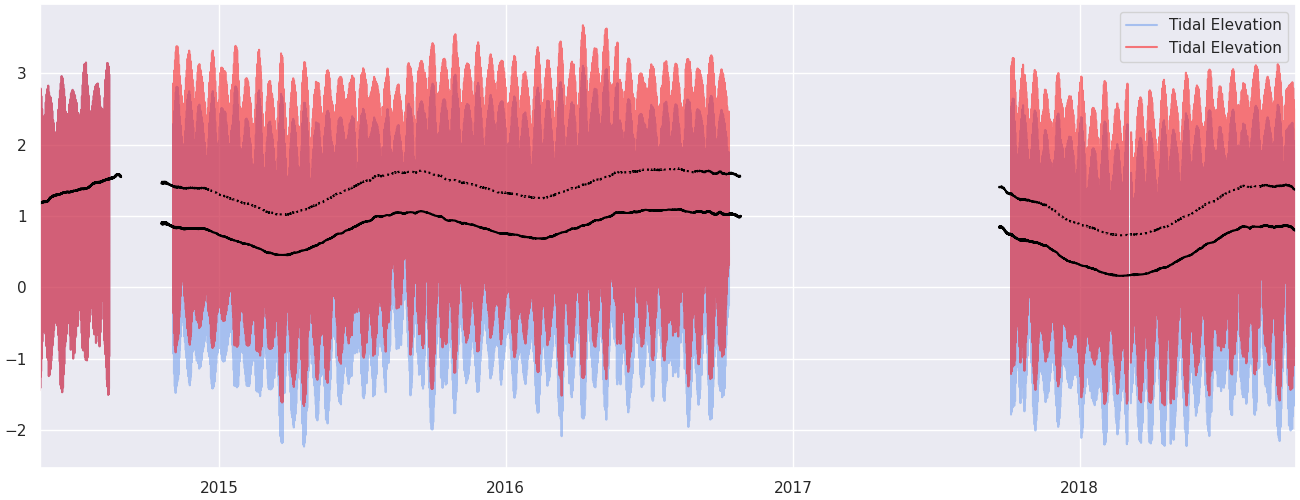

In [416]:
left = data.rolling(window=window, center=True, min_periods=min_periods).median().loc[gap.start]
right = data.rolling(window=window, center=True, min_periods=min_periods).median().loc[gap.end]

offset = left - right
lm_offset = preds[0] - preds[-1]
adj = offset - lm_offset

new = data.copy()
new.loc[gap.end:] = new.loc[gap.end:] + adj

fig, ax = plt.subplots(figsize=(13, 5), constrained_layout=True)

data.iloc[::6].plot(kind="line", ax=ax, label="Tidal Elevation", legend=True, color="cornflowerblue", alpha=0.5)
new.iloc[::6].plot(kind="line", ax=ax, label="Tidal Elevation", legend=True, color="red", alpha=0.5)

data.rolling(window=window, center=True, min_periods=min_periods).median().iloc[::6].plot(kind="line", ax=ax, color="black")
new.rolling(window=window, center=True, min_periods=min_periods).median().iloc[::6].plot(kind="line", ax=ax, color="black", ls=":")

ax.set_xlim(data.index[0], data.index[-1])
ax.set_xlabel("");


In [417]:
data = new

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
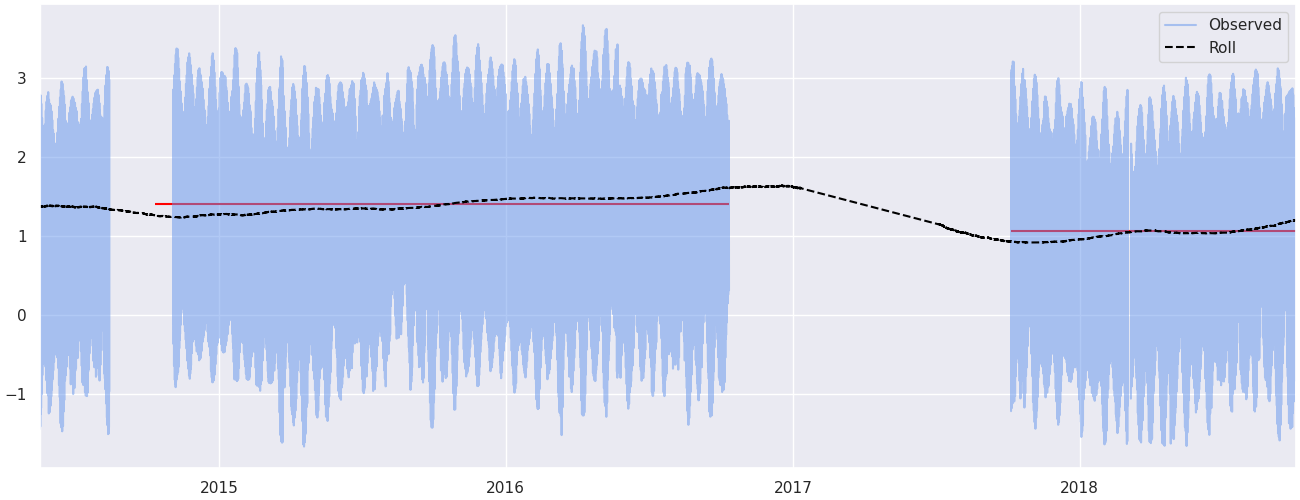

In [418]:
gap = gaps.loc[4]

window = pd.Timedelta("365.25D")
min_periods = window / 4 // data.index.freq

roll = data.rolling(window=window, center=True, min_periods=min_periods).median().interpolate(method="time", limit_direction="both")

left_median = data.loc[gap.start-window*2:gap.start].median()
right_median = data.loc[gap.end:].median()

fig, ax = plt.subplots(figsize=(13, 5), constrained_layout=True)

step = 6

data.iloc[::step].plot(kind="line", color="cornflowerblue", alpha=0.5, ax=ax, label="Observed", legend=True)
roll.iloc[::step].plot(kind="line", ax=ax, color="black", label="Roll", ls="--", legend=True)

ax.hlines(y=left_median, xmin=gap.start-window*2, xmax=gap.start, color="red")
ax.hlines(y=right_median, xmin=gap.end, xmax=data.index[-1], color="red")

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
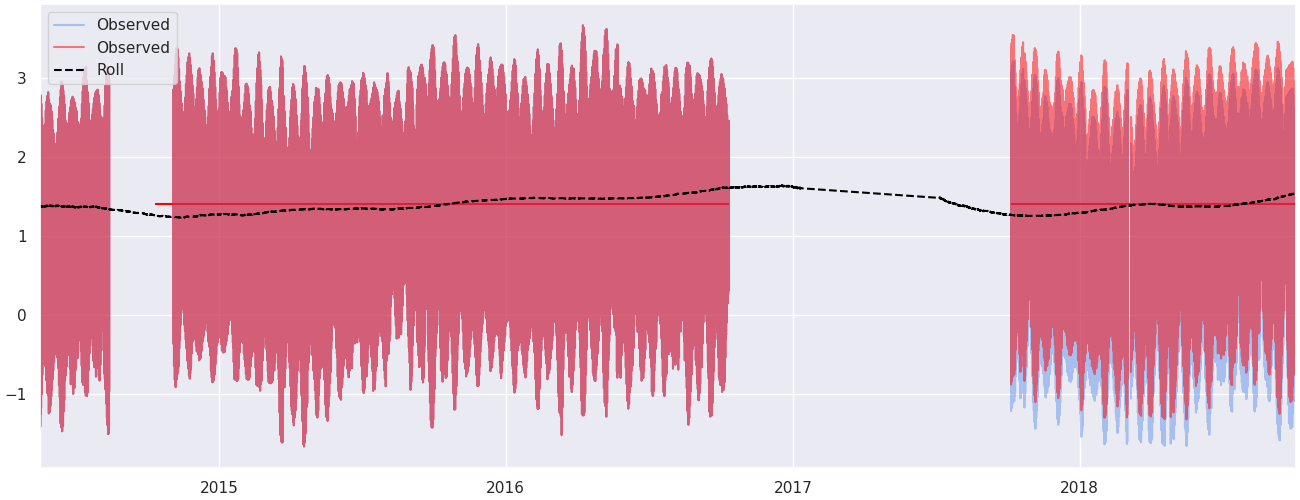

In [419]:
new = data.copy()

gap_diff = data.loc[gap.start-window*2:gap.start].median() - data.loc[gap.end:].median()

new.loc[gap.end:] = new.loc[gap.end:] + gap_diff

window = pd.Timedelta("365.25D")
min_periods = window / 4 // data.index.freq
roll = new.rolling(window=window, center=True, min_periods=min_periods).median().interpolate(method="time", limit_direction="both")

left_median = new.loc[gap.start-window*2:gap.start].median()
right_median = new.loc[gap.end:].median()

fig, ax = plt.subplots(figsize=(13, 5), constrained_layout=True)

step = 6

data.iloc[::step].plot(kind="line", color="cornflowerblue", alpha=0.5, ax=ax, label="Observed", legend=True)
new.iloc[::step].plot(kind="line", color="red", alpha=0.5, ax=ax, label="Observed", legend=True)
roll.iloc[::step].plot(kind="line", ax=ax, color="black", label="Roll", ls="--", legend=True)

ax.hlines(y=left_median, xmin=gap.start-window*2, xmax=gap.start, color="red")
ax.hlines(y=right_median, xmin=gap.end, xmax=data.index[-1], color="red")

In [420]:
data = new

In [421]:
data = data.to_frame(name="elev")

data[["high", "low"]] = False
distance = pd.Timedelta("1H") / data.index.freq * 8

hi = find_peaks(x=data.elev.values, distance=distance)[0]
lo = find_peaks(x=data.elev.values * -1, distance=distance)[0]

data.loc[data.iloc[hi].index, "high"] = True
data.loc[data.iloc[lo].index, "low"] = True

data["high_roll"] = data.loc[data.high == True].elev.rolling(window=pd.Timedelta("27h"), center=True).mean().reindex(index=data.index).interpolate(method="time", limit_direction="both")
data["low_roll"] = data.loc[data.low == True].elev.rolling(window=pd.Timedelta("27h"), center=True).mean().reindex(index=data.index).interpolate(method="time", limit_direction="both")
data["amp_roll"] = data.high_roll - data.low_roll

window = pd.Timedelta("27 hour")
exog = (data.index - data.index[0]).total_seconds().astype(int).values
frac = window / pd.Timedelta(data.index.freq) / len(data)
endogs = (data.high_roll.values, data.low_roll.values)
high_smooth, low_smooth = Parallel(n_jobs=2, max_nbytes=None)(delayed(sm.nonparametric.lowess)(endog=endog, exog=exog, frac=frac, is_sorted=True) for endog in endogs)

data.loc[pd.TimedeltaIndex(list(zip(*high_smooth))[0], unit="s") + data.index[0], "high_smooth"] = list(zip(*high_smooth))[1]
data.loc[pd.TimedeltaIndex(list(zip(*low_smooth))[0], unit="s") + data.index[0], "low_smooth"] = list(zip(*low_smooth))[1]
data["amp_smooth"] = data.high_smooth - data.low_smooth

data[["spring", "neap"]] = False
distance = pd.Timedelta("1H") / data.index.freq * 24 * 11 # search distance in hours
hi = find_peaks(x=data.amp_smooth.values, distance=distance, height=3.0)[0]
lo = find_peaks(x=data.amp_smooth.values * -1, distance=distance, height=-3.0)[0]
data.loc[data.iloc[hi].index, "spring"] = True
data.loc[data.iloc[lo].index, "neap"] = True

In [422]:
flood_depth = 0.39 # Hale et al. max depth measurement from 2018-03-04
flood_height = data.high_smooth.loc["2017-09-07"].mean()
platform_height = flood_height - flood_depth

shift = 2.6 - platform_height # adjustmet to tidal data so that HW on 2018-03-04 is 0.39 m above a platform at 2.6 m

tides = (data.elev + shift).to_frame(name="obs")

In [456]:
monthly.rolling(window=pd.Timedelta("365.25D")*1.5, center=True).mean()

2014-05-01    0.978478
2014-06-01    0.900999
2014-07-01    0.900999
2014-08-01    0.877787
2014-09-01    0.892664
2014-10-01    0.910166
2014-11-01    0.948072
2014-12-01    0.948072
2015-01-01    0.985154
2015-02-01    1.003893
2015-03-01    1.003893
2015-04-01    1.006795
2015-05-01    0.999388
2015-06-01    0.992797
2015-07-01    0.988232
2015-08-01    0.998202
2015-09-01    1.006840
2015-10-01    1.022695
2015-11-01    1.038098
2015-12-01    1.097619
2016-01-01    1.133136
2016-02-01    1.147665
2016-03-01    1.154746
2016-04-01    1.158465
2016-05-01    1.139659
2016-06-01    1.129490
2016-07-01    1.123927
2016-08-01    1.130301
2016-09-01    1.139758
2016-10-01    1.170266
2016-11-01    1.209742
2016-12-01    1.258834
2017-01-01    1.298584
2017-02-01    1.265778
2017-03-01    1.265778
2017-04-01    1.207038
2017-05-01    1.129438
2017-06-01    0.982729
2017-07-01    0.934354
2017-08-01    0.922032
2017-09-01    0.950521
2017-10-01    0.989263
2017-11-01    1.038142
2017-12-01 

<AxesSubplot:>

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
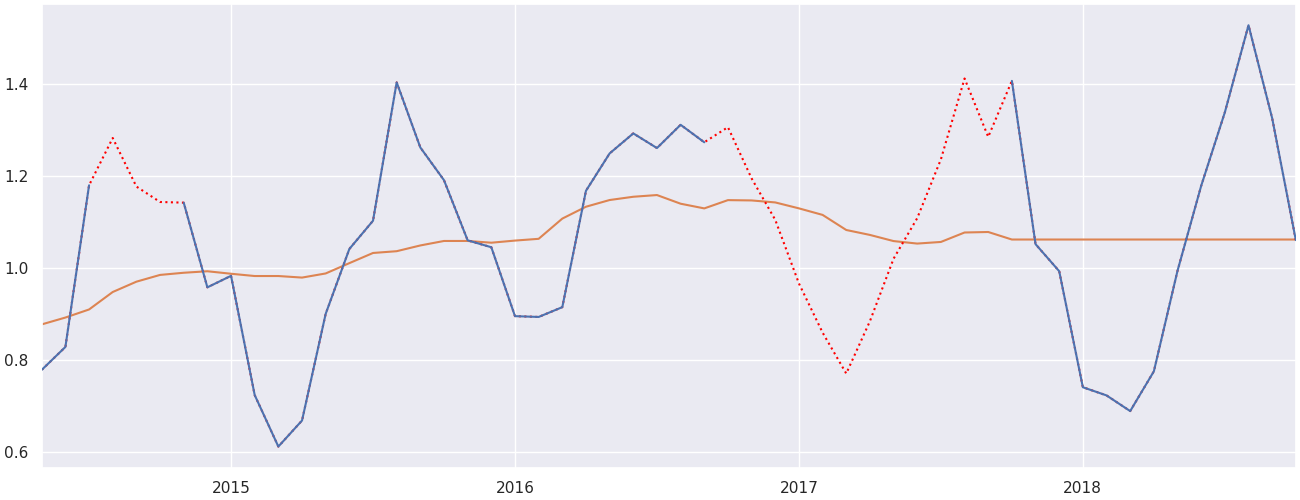

In [458]:
fig, ax = plt.subplots(figsize=(13, 5), constrained_layout=True)

monthly = tides.obs.groupby(by=pd.Grouper(freq="MS")).median()
null_frac = tides.obs.groupby(by=pd.Grouper(freq="MS")).apply(lambda x: x.isnull().mean())
monthly.loc[null_frac > 0.3] = np.nan
monthly.plot(ax=ax, zorder=10)

trend = monthly.rolling(window=pd.Timedelta("365.25D")*2, center=True).mean()
trend.plot(ax=ax)

monthly = monthly - trend
mean_monthly = monthly.groupby(monthly.index.month).mean()
monthly.loc[monthly.isnull()] = mean_monthly.loc[monthly.loc[monthly.isnull()].index.month].values
monthly = monthly + trend

monthly.plot(ax=ax, color="red", ls=":")

In [459]:
stl = STL(endog=monthly, seasonal=13, robust=True)
res = stl.fit()

tides["seasonal"] = res.seasonal.reindex(index=tides.index).interpolate(method="time", limit_direction="both")
tides["trend"] = res.trend.reindex(index=tides.index).interpolate(method="time", limit_direction="both")
mean_seasonal = tides.seasonal.groupby(tides.index.month).mean()

res.plot();

ValueError: trend must be an odd positive integer >= 3 where trend > period

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
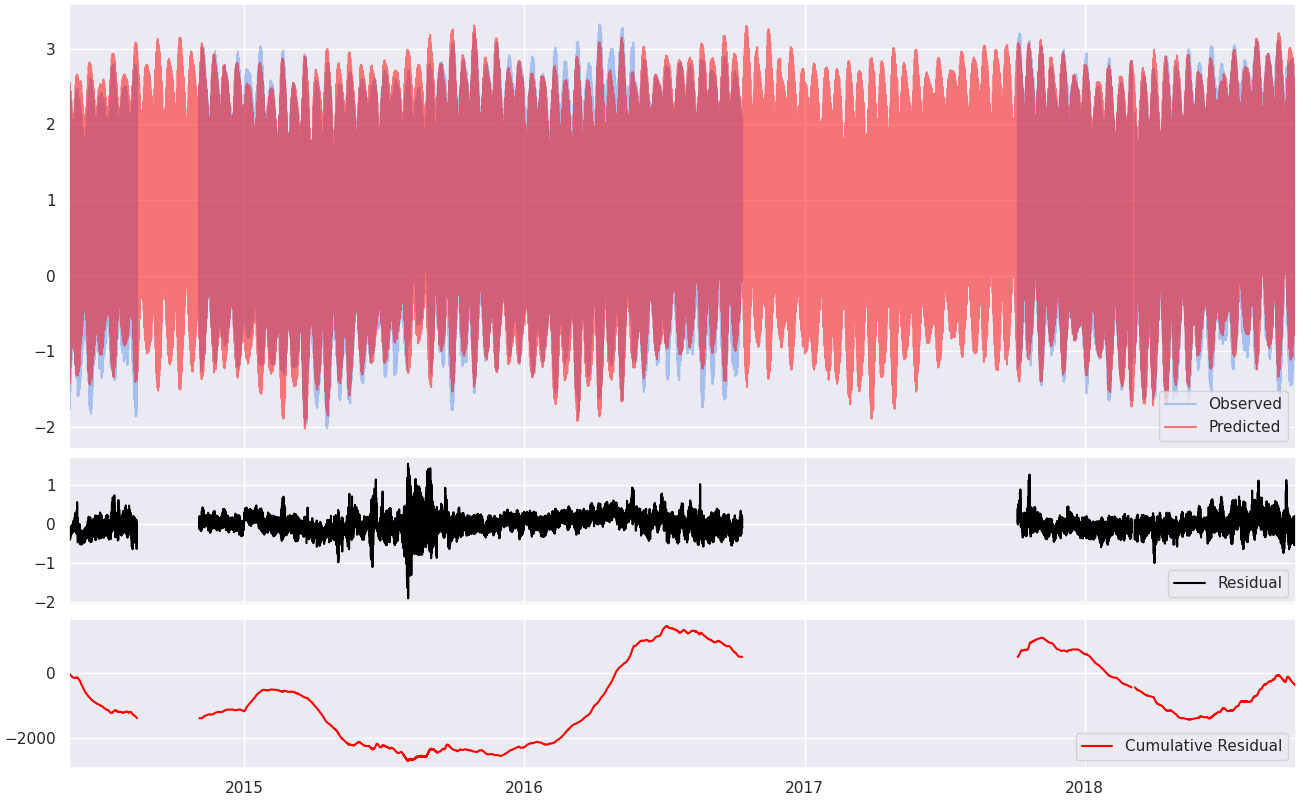

In [374]:
lat = 22.49984514299519
subset = tides
elev = (subset.obs - subset.trend - subset.seasonal).values
time = mdates.date2num((subset.index - pd.Timedelta("6 hours")).to_pydatetime())

coef = utide.solve(t=time, u=elev, lat=lat, conf_int="MC", method="ols", trend=False, nodal=True, constit="auto", verbose=False)
tides["pred"] = utide.reconstruct(t=mdates.date2num((data.index - pd.Timedelta("6 hours")).to_pydatetime()), coef=coef, verbose=False).h + tides.trend + mean_seasonal.loc[tides.index.month].values
tides["res"] = tides.obs - tides.pred

fig, (ax1, ax2, ax3) = plt.subplots(figsize=(13, 8), nrows=3, ncols=1, sharex=True, gridspec_kw={'height_ratios': [3, 1, 1]}, constrained_layout=True)

step = 6

tides.iloc[::step].obs.plot(kind="line", color="cornflowerblue", alpha=0.5, ax=ax1, label="Observed", legend=True)
tides.iloc[::step].pred.plot(kind="line", color="red", alpha=0.5, ax=ax1, label="Predicted", legend=True)
tides.iloc[::step].res.plot(kind="line", ax=ax2, color="black", label="Residual", legend=True)
tides.res.cumsum().iloc[::step].plot(kind="line", ax=ax3, color="red", label="Cumulative Residual", legend=True)

ax3.set_xlim(tides.index[0], tides.index[-1]);
ax3.set_xlabel("");

ax1.legend(loc='lower right')
ax2.legend(loc='lower right')
ax3.legend(loc='lower right')

In [426]:
tides.obs.to_csv(wdir / "processed" / "sutarkhali_adjusted.csv", index_label="datetime")

In [425]:
tides

,obs,seasonal,trend
2014-05-17 21:00:00,-1.795398,-0.079012,0.937502
2014-05-17 21:10:00,-1.785898,-0.079012,0.937502
2014-05-17 21:20:00,-1.780898,-0.079012,0.937502
2014-05-17 21:30:00,-1.780898,-0.079012,0.937502
2014-05-17 21:40:00,-1.749398,-0.079012,0.937502
...,...,...,...
2018-10-03 11:40:00,-0.401312,0.135918,1.083238
2018-10-03 11:50:00,-0.439312,0.135918,1.083238
2018-10-03 12:00:00,-0.456312,0.135918,1.083238
2018-10-03 12:10:00,-0.469312,0.135918,1.083238
